In [1]:
import pyarrow.parquet as parquet
import pyarrow.feather as feather
import pyarrow.orc as orc
import pyarrow.csv as csv
import pyarrow as pa
from pathlib import Path
import gc
import time
import os
import psutil
import json
from timeit import default_timer as timer
from datetime import timedelta
import pandas as pd

reddit_place = '2022_place_canvas_history'
original_csv_file = f'data/small/day1/original/{reddit_place}.csv'
#parquet_file = f'data/small/day1/{reddit_place}.parquet'
#feather_file = f'data/small/day1/{reddit_place}.feather'
#orc_file = f'data/small/day1/{reddit_place}.orc'
#csv_file = f'data/small/day1/{reddit_place}.csv'

compressed_folder = 'data/small/day1/compressed'
feather_compressions = ['lz4', 'zstd', 'uncompressed']
orc_compressions = ['zlib', 'snappy', 'lz4', 'zstd', 'uncompressed']
parquet_compressions = ['zstd', 'lz4', 'brotli', 'gzip', 'snappy', 'none']
csv_compressions = ["infer", "gzip", "bz2", "zip", "xz", "zstd"]
filetypes = ['parquet', 'orc', 'feather', 'csv']
compression_lists = [
    parquet_compressions,
    orc_compressions,
    feather_compressions,
    csv_compressions
]

In [2]:
with open('compression_final.json', 'r', encoding='utf8') as jfile:
    data = json.load(jfile)


In [3]:
from collections import defaultdict
filenames = [file_test['filename'] for file_test in data[0]]

file_dict = defaultdict(list)

for test_number, test_group in enumerate(data, start=1):
    for file_test in test_group:
        filename = file_test['filetype']
        file_dict[filename].append({'test_number': test_number, **file_test})


In [4]:
new_dict = dict()
for filetype, tests in file_dict.items():
    compression_dict = defaultdict(list)
    for test in tests:
        compression = test['compression']
        compression_dict[compression].append({**test})
    
    new_dict[filetype] = {
        **compression_dict
    }
    

In [94]:
file_tests = {}
for filetype, file_results in new_dict.items():
    file_tests[filetype] = {}
    for compression, tests in file_results.items():
        read_times = []
        write_times = []
        filesizes_in_bytes = []
        for test in tests:
            read_times.append(test['read_time_in_seconds'])
            write_times.append(test['write_time_in_seconds'])
            filesizes_in_bytes.append(test['filesize_in_bytes'])

        file_tests[filetype][compression] = {
            'read_times': read_times,
            'write_times': write_times,
            'filesizes_in_bytes': filesizes_in_bytes,
            'mean_read_time': np.mean(read_times),
            'mean_write_time': np.mean(write_times),
            'mean_filesize_in_bytes': np.mean(filesizes_in_bytes),
            'mean_filesize_in_GB': np.mean(filesizes_in_bytes) / (10 ** 9) 
        }

with open('group_compression_tests.json', 'w', encoding='utf8') as jfile:
    json.dump(file_tests, jfile, indent=4)

In [6]:
import matplotlib.pyplot as plt

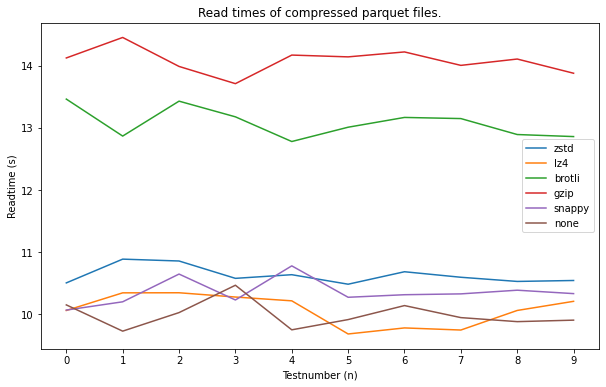

In [84]:
import math
plt.figure(figsize=(10, 6))
plt.xticks(range(10))
plt.ylabel('Readtime (s)')
plt.xlabel('Testnumber (n)')
plt.title('Read times of compressed parquet files.')

for compression, tests in file_tests['parquet'].items():
    plt.plot(tests['read_times'], label=compression)
    plt.legend()
#y_start = math.floor(min(write_times))
#y_end = math.ceil(max(write_times))
#plt.yticks(range(y_start - 1, y_end + 1))

plt.show()


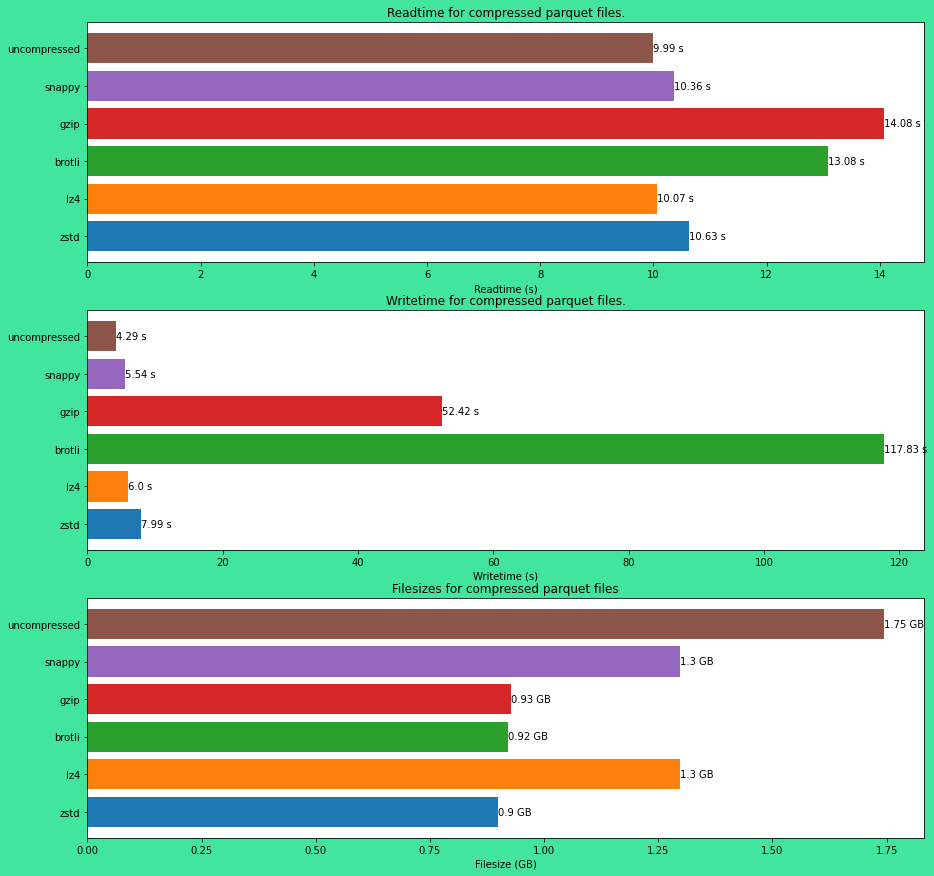

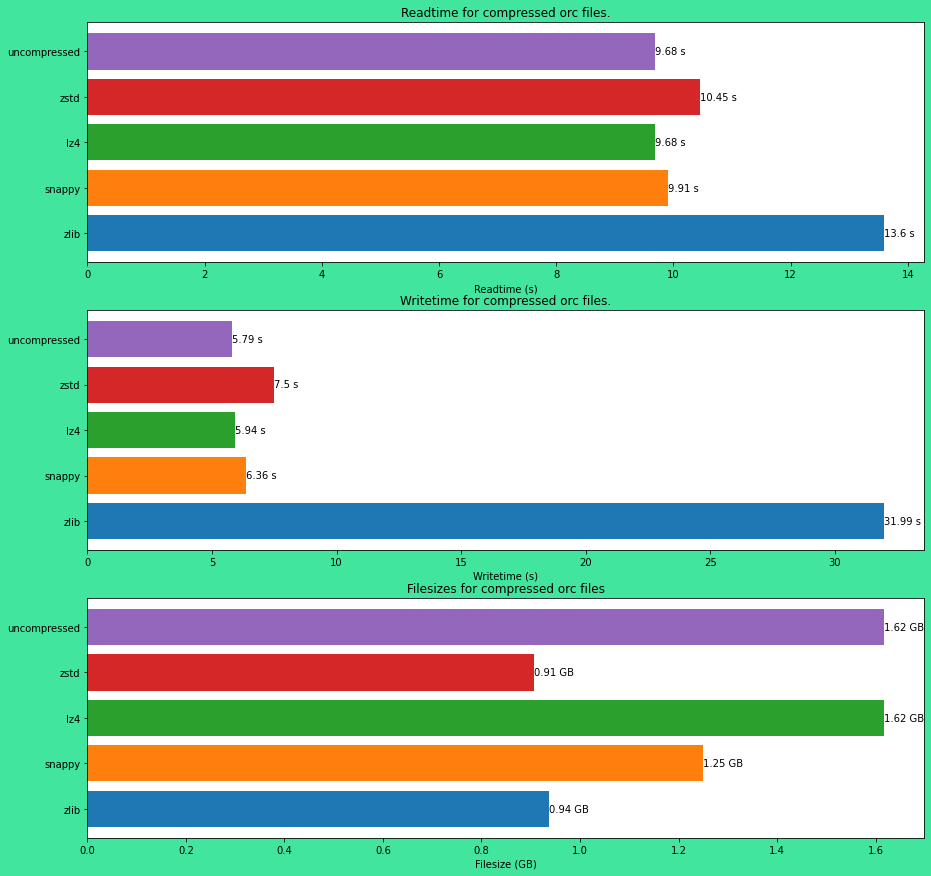

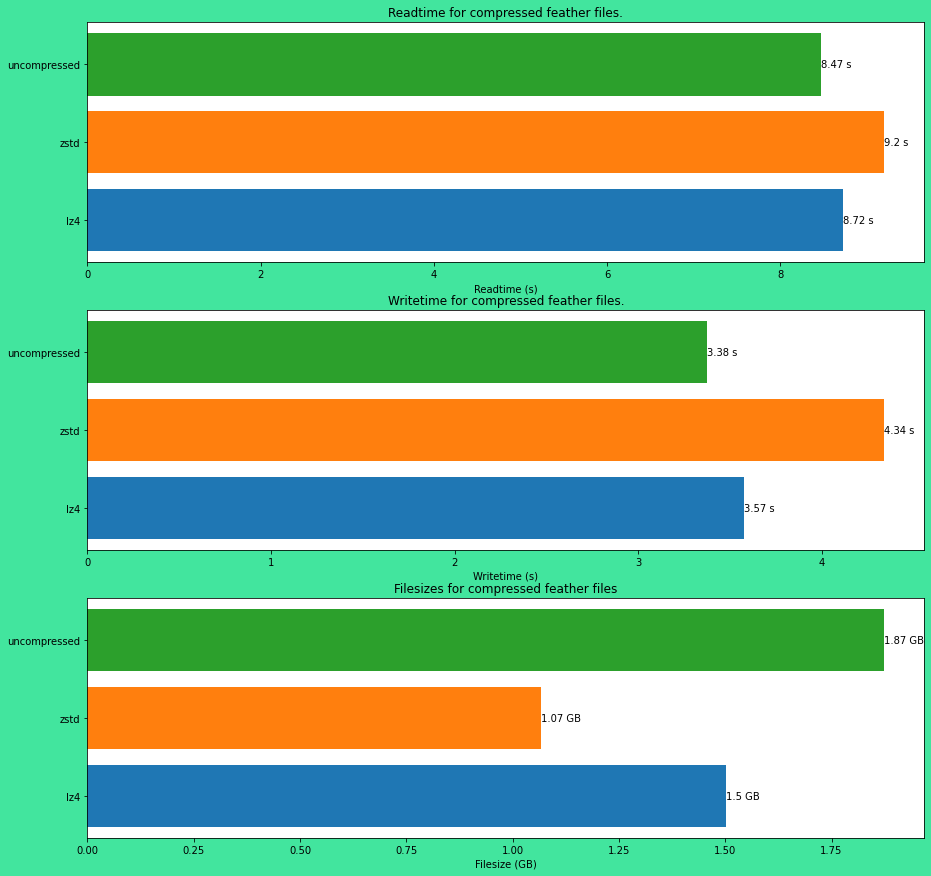

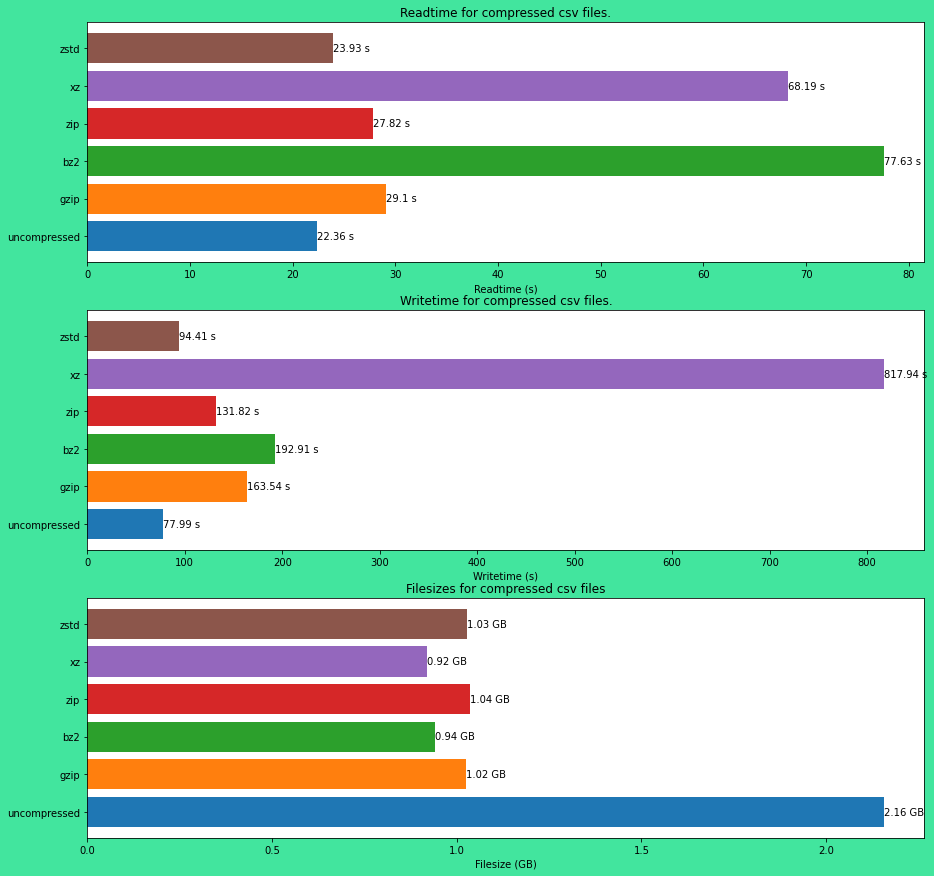

In [93]:
for filetype in file_tests.keys():
    fig, axs = plt.subplots(3, figsize=(15,15), facecolor='#42e59e')
    titles = [
        f'Readtime for compressed {filetype} files.',
        f'Writetime for compressed {filetype} files.',
        f'Filesizes for compressed {filetype} files'
    ]
    suffixes = ['s', 's', 'GB']
    x_labels = [
        f'Readtime ({suffixes[0]})',
        f'Writetime ({suffixes[1]})', 
        f'Filesize ({suffixes[2]})'
    ]
    data_keys = ['mean_read_time', 'mean_write_time', 'mean_filesize_in_GB']

    for i, key in enumerate(data_keys):
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(x_labels[i])
        for compression, tests in file_tests[filetype].items():
            c_map = {'infer': 'uncompressed', 'none': 'uncompressed'}
            bar = axs[i].barh(c_map.get(compression, compression), width=tests[key])
            rounded_value = np.round(tests[key], 2) 
            axs[i].bar_label(bar, [f'{rounded_value} {suffixes[i]}'])

    plt.savefig(f'graphs/compression/{filetype}.PNG')

brotli 117.831302361493
gzip 52.42010339049739


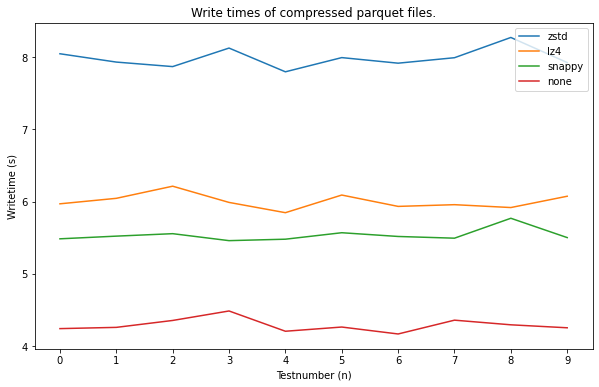

In [18]:
plt.figure(figsize=(10, 6))
plt.xticks(range(10))
plt.ylabel('Writetime (s)')
plt.xlabel('Testnumber (n)')
plt.title('Write times of compressed parquet files.')

for compression, tests in parquet_tests.items():
    if compression not in ['brotli', 'gzip']:
        plt.plot(tests['write_times'], label=compression)
        plt.legend()
    else:
        print(compression, np.mean(tests['write_times']))

plt.show()

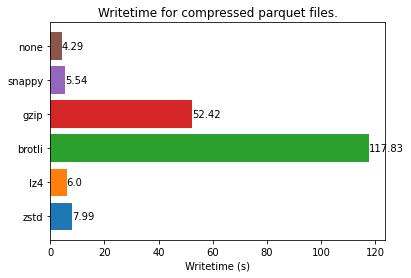

<Figure size 720x432 with 0 Axes>

In [63]:
fig, ax = plt.subplots()
plt.figure(figsize=(10, 6))
ax.set_title('Writetime for compressed parquet files.')
ax.set_xlabel('Writetime (s)')
for compression, tests in parquet_tests.items():
    #x_error = np.max(tests['read_times']) - np.min(tests['read_times'])
    #print(x_error)
    bar = ax.barh(compression, width=tests['mean_write_time'])
    ax.bar_label(bar, [np.round(tests['mean_write_time'], 2)])
#for compression, tests in parquet_tests.items():

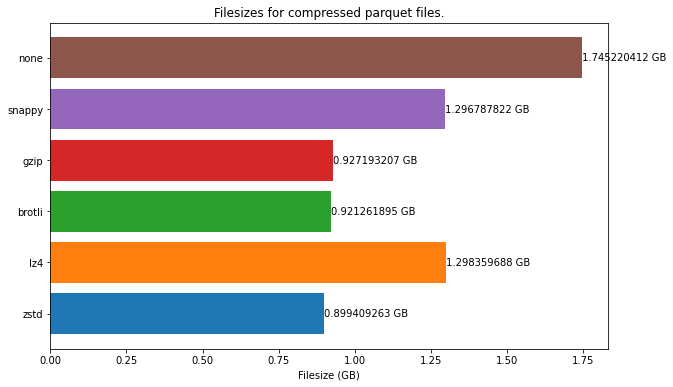

In [71]:
import numpy as np
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Filesizes for compressed parquet files.')
ax.set_xlabel('Filesize (GB)')
for compression, tests in parquet_tests.items():
    file_sizes_in_GB = np.array(tests['mean_filesize_in_bytes']) / 1000000000
    bar = ax.barh(compression, width=file_sizes_in_GB)
    ax.bar_label(bar, [f'{file_sizes_in_GB} GB'])

plt.show()